*Adam Olivares Canal, Mahmoud El Daou, Berta Canal Simón*

# Variational Autoencoders (VAEs)

# 1. Introduction

Introduced by Kingma and Welling (2013), Variational Autoencoders (referred as VAEs) are a type of probabilistic model designed to identify latent, low-dimensional representations of data. Consequently, VAEs serve as a technique for dimensionality reduction, simplifying data to their essential dimensions.

Diverging from the classical autoencoder that directly encodes input into a latent vector, VAEs encode input data into the parameters defining a probability distribution, tipically the mean and variance for a Gaussian distribution. This method yields a continuous and organized latent space, advantageous for tasks such as image generation.

In the context of Variational Inference, VAEs introduce a significant improvement by using a technique known as amortized variational inference. Unlike VI methods where each data point in a dataset requires separate optimization of variational parameters, VAEs employ a single encoder neural network to infer these parameters jointly for all data points. This approach allows for the sharing of variational parameters across the dataset, thereby avoiding the need for individual optimization loops for each data point and harnessing the efficiency of Stochastic Gradient Descent.

A key benefit of this framework is that the recognition model, which is part of the VAE architecture, acts as a stochastic function of the input variables. This is opposed to VI, where each case in the data set has its own distinct variational distribution, making it inefficient for large datasets. The recognition model in a VAE, by using a single set of parameters, simplifies the modeling of relationships between input and latent variables. Despite the complexity that may arise within this recognition model, it remains reasonably fast due to the use of a single feedforward pass from input to latent variables. However, this method does introduce some level of sampling noise into the gradient calculations necessary for learning. The VAEs framework addresses this issue with the *reparameterization trick*, a strategy to reorganize gradient computation that effectively reduces variance in the gradients, balancing the trade-off between computational efficiency and the quality of the inference.

In this project, our objective is to conduct an in-depth exploration of VAEs, using the TensorFlow tutorial on the MNIST dataset to reveal both the practical uses and theoretical foundations. Therefore, it aims to provide a comprehensive understanding from the probabilistic foundations to the practical implications.

 # 2. Tutorial of VAEs

## 2.1. Set up

In [1]:
!pip install tensorflow-probability -q
!pip install imageio -q
!pip install git+https://github.com/tensorflow/docs -q

In [3]:
from IPython import display

import glob
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

## 2.2. Load the MNIST dataset

Every image in the MNIST dataset starts as a 784-integer vector, with each integer ranging from 0 to 255, indicating the pixel's intensity.

In [4]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

### Preprocess images function

The `preprocess_images` function first reshapes the input images to have a consistent size (28x28 pixels) and a single color channel, normalizing the pixel values by dividing by 255 to scale them between 0 and 1. Then, it binarizes the images by setting pixels with values greater than 0.5 to 1 and those less than or equal to 0.5 to 0. This aims to represent each pixel using a Bernoulli distribution within our model, and to statically binarize the dataset.

Then, the function is applied to both training and testing image datasets previously loaded.

In [5]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

### Batch size

In model training, the batch size represents the number of training samples processed in each iteration, affecting how model parameters are updated. Small batches introduce noise that may aid in escaping local minima and enhance generalization but are less computationally efficient. Large batches ensure more accurate gradient estimates, promoting stable updates and potentially faster convergence but require significant memory and computational power, possibly impacting generalization due to convergence to sharper minima. 

The choice of the batch size has to attend a trade-off between the computational efficiency of larger batches and the potential for better generalization with smaller batches. Note also that the notion of "small" and "large" batches is relative to the size of the dataset.

In this case, the chosen batch size of 32 means that 32 images will be processed at a time during the training of the model.

In [6]:
batch_size = 32

### Train and test size

The code assigns the total number of images in the training and testing datasets to train_size and test_size, respectively. Specifically, train size is set to the size of the *train_images* array, which contains 60,000 images, while test size is set to the size of the *test_images* array, which includes 10,000 images. 

In [7]:
train_size = len(train_images)
test_size = len(test_images)

## 2.3. Use *tf.data* to batch and shuffle the data

This code constructs TensorFlow datasets for both training and testing images, shuffles them to randomize the order, and organizes them into batches.

In [8]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

## 2.4. Encoder and decoder networks in TensorFlow

For this TensorFlow VAE example, two convolutional networks for the encoder (a.k.a. recognition model) and decoder (a.k.a. generative model) networks were used. `tf.keras.Sequential` is used to make a simple implementation of neural networks.  $\boldsymbol{x}$ and $\boldsymbol{z}$ are random vectors corresponding to the observation and latent variables respectively.

For the encoder network, the example used two convolutional layers followed by a fully-connected layer. In the decoder network, the architecture was mirrored by using a fully-connected layer followed by three convolution transpose layers. Note that it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to the use of mini-batches may worsen instability on top of the stochasticity from sampling.

We break down the code into pieces to go in detail over what is happening in each step of the process:

### A. Class initialization of the Convolutional VAE model (CVAE)

Before building the econder and decoder layers of this convolutional network, we initialize the Convolutional VAE model, setting the latent dimension and defining the encoder and decoder networks.

The preference for convolutional layers in many VAE implementations we found, especially for image data, is due to the inherent properties of convolutional neural networks  that make them well-suited for high-dimensional settings, capturing the spatial hierarchies and local patterns in images. Note that other neural network structures, like feed-forward layers, could be used.

#### A.1 Encoder Network (Recognition model)

The encoder part of the provided code, composed of convolutional layers followed by a dense layer, corresponds to the approximate posterior $q_{\phi}(\boldsymbol{z}|\boldsymbol{x})$. This network aims to encode the input data $\boldsymbol{x}$ into a latent representation $\boldsymbol{z}$, parameterized by $\boldsymbol{\mu}$ (mean) and $\boldsymbol{\sigma}$ (log variance). This recognition model is intended to act as a mechanism to learn an efficient approximation of the intractable true posterior distribution of the latent variables given the input.

Log variance (expressed as *logvar* in the code) is used instead of the variance for numerical stability. Notice that directly optimizing the variance could lead to negative values due to floating-point arithmetic errors or optimization overshoots, causing training instability or leading to illogical latent representations.

This example models the distribution as a diagonal Gaussian for simplicity purposes, and the network outputs the mean and log variance parameters of a factorized Gaussian. Assuming a diagonal Gaussian distribution simplifies the model by allowing each dimension of the latent space to be independent of the others, thus allowing to undestand and manipulate each dimension of the latent space separately. Working with diagonal covariance matrices is computationally more efficient than full-covariance matrices because in this later case the network would need to output a significantly larger number of parameters. If we wanted to switch to a full-covariance Gaussian posterior, the formula of the reparameterization must be modified.

#### A.1.1 Input layer 

It specifies the input shape of the images (28x28 pixels with 1 color channel). This is the configuration required to input the MNIST image dataset, where each image is a grayscale 28 x 28 (784 pixels) handwritten digit from "0" to "9". 

#### A.1.2 Convolutional layers

In this example we deal with two layers with 32 and 64 filters, respectively, using a kernel size of 3 and stride of 2. These layers capture spatial hierarchies of features from the input images and reduce the dimensionality.

In convolutional layers:
 * Increasing the number of filters would allow the encoder to capture more detailed features at the cost of computational complexity, potentially leading to a more accurate but slower training process. 
 * Decreasing the kernel size might help in capturing finer details, but may require more layers to maintain a similar receptive field.
 
 * Reducing the stride size would result in a slower reduction of spatial dimensions, potentially capturing more detailed information but increasing the computational load and the risk of overfitting. Contrarily, increasing the stride size would speed up dimensionality reduction, possibly losing detail in the process.

An alternative that could improve the model output is to increase the network size, although the training time would also increase. For example, setting the `filters` parameters for each of the `Conv2D` and `Conv2DTranspose` layers to 512.

#### A.1.3 Flatten layer

It converts the 2D feature maps into a 1D vector required for the dense layer.

#### A.1.4 Dense layer

It outputs a vector of size `latent_dim` + `latent_dim`, intended to represent the mean and log variance of each latent variable $\boldsymbol{z}$, which are crucial for defining the distribution from which we sample. As we will see later, being able to sample from the latent space in a differentiable manner is critical for the reparameterization trick.

Altering the output size of the dense layer (which outputs mean and log variance) directly affects the dimensionality of the latent space. Increasing this size would allow the model to encode more information in the latent space, possibly improving the quality of the generated/reconstructed images at the expense of making the latent space less interpretable and increasing the runtime.

#### A.2 Decoder Network (Generative model)

The decoder network is designed to reconstruct the input data from the latent representation, acting as the generative model $p_{\boldsymbol{\theta}}(\mathbf{z}|\mathbf{x})$, which takes a latent sample $\boldsymbol{z}$ as input and outputs the parameters for a conditional distribution of the observation. The final output of the decoder can be interpreted as the parameters of the data distribution given the latent variables. 

Here, the latent distribution prior $p_{\boldsymbol{\theta}}(\mathbf{z})$ is modeled as a unit Gaussian for simplicity and mathematical convenience, but it could be modeled using a different distribution, such as a uniform distribution or a mixture of Gaussians. This might be beneficial if there's prior knowledge about the data that suggests a different distribution would be a better fit for the latent space. Nonetheless, changing to a non-Gaussian distribution could complicate the calculation of the KL divergence term in the VAE loss function, as closed-form solutions might not be available. This may require approximations or numerical methods. 


#### A.2.1 Input layer

It takes a latent space vector of size `latent_dim`.

#### A.2.2 Dense layer

This layer upscales the input to a dimensionality that can be reshaped for convolutional layers (7x7x32).

Changing the number of units in the first dense layer of the decoder (which upscales the latent vector) would affect the amount of information that can be processed and reconstructed from the latent space. A higher number of units might improve the reconstruction quality but increase the risk of overfitting and computational cost.

#### A.2.3 Reshape layer

It changes the shape of the output from the dense layer to match the expected input shape of the next convolutional layers.

#### A.2.4 Transposed convolution layers (Deconvolutions)

Here we have three transposed convolution layers that upscale the feature maps back to the original image size. The need for this kind of layers arises from the necessity to go in the opposite direction of a normal convolution. The last layer outputs the reconstructed image with the same channel size as the input.

Adjusting these layers (e.g., changing filters, kernel size, or strides) would impact the upscaling process and how well the decoder can reconstruct images from the latent representations. 

### B. Sampling function

The sample method in the code allows generating new data points by sampling from the latent space and passing these samples through the decoder. This process is reflective of the generative capability of VAE.

`sample(self, eps=None)` generates new data points by sampling from the latent space. If no specific *eps* is provided, it samples from a standard normal distribution.

Modifying the distribution from which *eps* is drawn could affect the diversity of the generated images. For instance, using a distribution with a wider variance might translate into more varied but potentially less realistic samples.

### C. Encoder function

The function `decode` processes the input $\boldsymbol{x}$ through the encoder network defined in the example, splitting the output into mean and log variance components of the latent variables.

### D. Reparameterization trick function

With the reparameterization trick, the latent variable $\boldsymbol{z}$ is now generated by a function of $\boldsymbol{\mu}$, $\boldsymbol{\sigma}$ and $\boldsymbol{\epsilon}$, which would enable the model to backpropagate gradients in the encoder through $\boldsymbol{\mu}$ and $\boldsymbol{\sigma}$ respectively, while maintaining stochasticity through $\boldsymbol{\epsilon}$. Specifically, $\boldsymbol{z} = \boldsymbol{\mu} + \boldsymbol{\sigma} \odot \boldsymbol{\epsilon}$, where $\boldsymbol{\epsilon}$ is an auxiliary noise variable drwan from a standard normal, enables the model to be differentiable and thus trainable via stochastic gradient descent. In this case, since we are working with log variance instead of variance, the formula is adapted to $\boldsymbol{z} = {\textit{mean}} + \exp({\textit{logvar}} / 2) \odot \boldsymbol{\epsilon}$, where $\exp({\textit{logvar}} / 2)$ is the standard deviation $\boldsymbol{\sigma}$ and *mean* is $\boldsymbol{\mu}$.

<br>
<div style="text-align: center;">
<img src="https://d3i71xaburhd42.cloudfront.net/329b84a919bfd1771be5bd14fa81e7b3f74cc961/26-Figure2.3-1.png" width="500"/>
<div style="margin-top: 10px;">Figure 1: Illustratrion of the reparameterization trick. </div>
<div style="margin-top: 5px; font-size: smaller; color: grey;">Image source: Kingma & Welling (2014)</div>
</div>
<br>

The defined function `reparameterize` applies the reparameterization trick, allowing gradient descent through the sampling process by generating samples from the distribution defined by *mean* and *logvar*.

Changing how the noise *eps* is applied or modifying the calculation (e.g., using a different approach to combine *mean*, *logvar*, and *eps*) could influence the stochasticity of the latent space. This would directly impact the model's ability to explore and generate diverse outputs.

### E. Decoder function

The function `decode` reconstructs the input data starting from its latent space representation. The reconstruction process involves transforming the latent variables $ \mathbf{z} $ through the decoder network back into the original data space. If `apply_sigmoid` is true, the output is passed through a sigmoid function, converting the logits into probabilities, which is useful for binary cross-entropy loss in case the input data is normalized.

<br>
<div style="text-align: center;">
    <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/0*SZ5esrCn2MDKmpHe.png" width="600"/>
    <div style="margin-top: 10px;">Figure 2: Architecture of a VAE, featuring the latent space representation along with the encoder and decoder convolutional neural networks. </div>
    <div style="margin-top: 5px; font-size: smaller; color: grey;">Image source: Weng, L. (2018)</div>
</div>

In [9]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  # A. Class initialization of the Convolutional VAE model
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    ## A.1 Encoder Network 
    self.encoder = tf.keras.Sequential(
        [
            ### A.1.1 Input layer 
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            ### A.1.2 Convolutional layers
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            ### A.1.3 Flatten layer
            tf.keras.layers.Flatten(),
            ### A.1.4 Dense layer
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )
    ## A.2 Decoder Network 
    self.decoder = tf.keras.Sequential(
        [
            ### A.2.1 Input layer
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            ### A.2.2 Dense layer
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            ### A.2.3 Reshape layer
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            ### A.2.4 Transposed convolution layers (Deconvolutions)
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  # B. Sampling function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)
  
  # C. Encoder function
  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  # D. Reparameterization trick function
  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  # E. Decoder function
  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

## 2.5. Define the loss function and the optimizer

### Loss function

The optimization objective of the VAE is to maximize the Evidence Lower Bound (ELBO), denoted as $ \mathcal{L}_{\boldsymbol{\theta},\boldsymbol{\phi}}(\mathbf{x}) $:

\begin{aligned}
\mathcal{L}_{\boldsymbol{\theta},\boldsymbol{\phi}}(\mathbf{x})=\log p_{\boldsymbol{\theta}}(\mathbf{x})-D_{KL}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})||p_{\boldsymbol{\theta}}(\mathbf{z}|\mathbf{x}))
\end{aligned}  

The term $D_{KL}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})||p_{\boldsymbol{\theta}}(\mathbf{z}|\mathbf{x}))$ refers to the Kullback-Leibler (KL) divergence between $ q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) $ and $ p_{\boldsymbol{\theta}}(\mathbf{z}|\mathbf{x}) $. Since the KL divergence is non-negative, the ELBO is a lower bound on the log-likelihood of the data:

\begin{aligned}
\mathcal{L}_{\boldsymbol{\theta},\boldsymbol{\phi}}(\mathbf{x})\leq\log p_{\boldsymbol{\theta}}(\mathbf{x}))
\end{aligned}

Note that maximizing the Evidence Lower Bound (ELBO) $ \mathcal{L}_{\boldsymbol{\theta},\boldsymbol{\phi}}(\mathbf{x}) $, with respect to the parameters $ \boldsymbol{\theta} $ and $ \boldsymbol{\phi} $, achieves two important objectives simultaneously: firstly, it leads to the approximate maximization of the marginal likelihood $ p_{\boldsymbol{\theta}}(\mathbf{x}) $, enhancing the performance of our generative model (decoder); secondly, it reduces the Kullback-Leibler (KL) divergence between the approximate posterior $ q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) $ and the true posterior $ p_{\boldsymbol{\theta}}(\mathbf{z}|\mathbf{x}) $, which refines the quality of our approximation $ q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) $.

In practice, we optimize the single sample Monte Carlo estimator $\tilde{\mathcal{L}}_{\boldsymbol{\theta},\boldsymbol{\phi}}(\mathbf{x})$ of
the individual-datapoint ELBO:

\begin{aligned}
&\boldsymbol{\epsilon}\sim p(\boldsymbol{\epsilon}) \\
&\mathbf{z} = \mathbf{g}(\boldsymbol{\phi}, \mathbf{x}, \boldsymbol{\epsilon}) \\
&\tilde{\mathcal{L}}_{\boldsymbol{\theta},\boldsymbol{\phi}}(\mathbf{x})=\log p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z})+\log p_{\boldsymbol{\theta}}(\mathbf{z})-\log q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})
\end{aligned}

where $\mathbf{z}$ is sampled from $q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})$ and $\boldsymbol{\epsilon}$ is a single noise sample from $p(\boldsymbol{\epsilon})$.

### Optimizer

This code initializes an Adam optimizer with a learning rate of 1e-4. 

Adam optimization is a variant of the stochastic gradient descent algorithm that utilizes adaptive estimation techniques for both first-order and second-order moments.

The learning rate controls how much the weights of the network are adjusted with respect to the loss gradient. Lower learning rates lead to slower convergence but can result in better accuracy by allowing the model to carefully adjust weights, avoiding overshooting the minimum. Higher learning rates speed up training but can cause instability or cause the model to settle at a suboptimal solution. 

In [10]:
optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

### Log Normal PDF function

The `log_normal_pdf` function computes the logarithm of the normal probability density function (PDF) for a specified sample, vital for calculating the probabilistic components of the loss function. Specifically, it calculates the log likelihood of the sampled latent variables under the prior, typically assumed to be a normal distribution $ \mathcal{N}(0,1) $, and under the posterior, denoted as $ \log p_{\boldsymbol{\theta}}(\mathbf{z}) $ and $ \log q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) $ respectively. The function accepts a latent space sample, its mean, its log variance, and the axis for summing probabilities as inputs.

In [11]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

### Compute loss function

The `compute_loss` function within a VAE framework encodes a batch of data $ \mathbf{x} $ to parameters *mean* and *logvar* representing the approximate posterior $ q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) $, samples a latent variable $ \mathbf{z} $ using these parameters via reparameterization, and decodes $ \mathbf{z} $ to reconstruct the input as *x_logit*. The reconstruction loss, which measures the accuracy of the reconstructed samples in relation to the original inputs, is computed as the  sigmoid cross entropy between $ \mathbf{x} $ and *x_logit* and computes the log-likelihood $ \log p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z}) $ from this loss. Additionally, it assesses $ \log p_{\boldsymbol{\theta}}(\mathbf{z}) $ and $ \log q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) $.

The function concludes by calculating the average negative Evidence Lower Bound (ELBO) across the batch, represented by the equation:

$$
-\frac{1}{N} \sum_{i=1}^{N} \left( -\log p_{\boldsymbol{\theta}}(\mathbf{x}_i | \mathbf{z}_i) + \log p_{\boldsymbol{\theta}}(\mathbf{z}_i) - \log q_{\boldsymbol{\phi}}(\mathbf{z}_i|\mathbf{x}_i) \right),
$$

where $ N $ is the number of samples in the batch, $ \mathbf{x}_i $ denotes the $ i $-th data point, and $ \mathbf{z}_i $ is the corresponding latent variable sampled from the posterior $ q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})$. 

Note that it aims to minimize the total loss in training to effectively maximize the ELBO.

In [12]:
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

### Train step function

The function `train_step` performs a single training step. It uses TensorFlow's GradientTape to record operations for automatic differentiation. Within the GradientTape block, it computes the loss for a batch of data $\mathbf{x} $. Then, it calculates the gradients of the loss with respect to the model's trainable parameters and applies these gradients to the parameters using the optimizer. This updates the model's weights in the direction that minimizes the loss.

In [13]:
@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## 2.6. Training

This section describes the training process for the VAE and how to generate new images after training:

1. **Iterate over the dataset**: The training process involves iterating over the dataset, where each iteration processes a batch of images.

2. **Encoding**: For each batch of images, the encoder part of the VAE is used to obtain a set of mean and log-variance parameters of the approximate posterior distribution $q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})$. This step transforms the input images into a latent space representation, where each image is represented by a distribution over the latent variables $ \mathbf{z} $.

3. **Reparameterization trick**: To sample from the approximate posterior $q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})$ while still allowing the gradient of the loss to backpropagate through the random sampling process, the reparameterization trick is applied.

4. **Decoding**: The reparameterized samples $ \mathbf{z} $ are then passed to the decoder to obtain the logits of the generative distribution $p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z})$. The decoder reconstructs the input images from the latent space, outputting the parameters of the probability distribution over the input space (in this case, logits corresponding to the Bernoulli distribution probabilities of each pixel being 1).


## Generating Images

After training, the model can generate new images by sampling from the latent space and decoding these samples:

1. **Sample latent vectors**: Start by sampling a set of latent vectors from the unit Gaussian prior distribution $p_{\boldsymbol{\theta}}(\mathbf{z})$. This involves generating random samples from a standard normal distribution, which represents the assumed prior over the latent variables.

2. **Generation**: The sampled latent vectors $ \mathbf{z} $ are passed to the generator (decoder of the VAE), which converts the latent samples into logits of the observation, giving a distribution $p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z})$.

3. **Plotting images**: To visualize the generated images, you typically convert the logits to probabilities using the sigmoid function (since the output models the parameters of Bernoulli distributions for each pixel) and then plot these probabilities. Each pixel's intensity is determined by the probability of being 1, resulting in grayscale images.

This training and generation process allows the VAE to learn a complex distribution over the input data and generate new samples that are similar to the original dataset, effectively capturing the underlying data distribution.

### Number of epochs
An epoch refers to one complete pass through the entire training dataset. Increasing the number of epochs can enhance the model's learning capabilities, potentially improving accuracy and the representation of data within the latent space due to more extensive optimization but raises the risk of overfitting and requires more computational resources. On the contrary, decreasing epochs shortens training time, which is beneficial for quick experimentation and when computational resources are limited, but raise the risk of failing to capture the underlying data patterns sufficiently.

In [14]:
epochs = 10

### Latent dimension

The latent space is a lower-dimensional space into which the input data is encoded. Setting the latent space dimension to 2 is particularly useful for visualization purposes, as it allows to plot the latent representations of the data as points in a plane.

In [15]:
latent_dim = 2

### Number of examples to generate

This specifies that 16 examples should be generated. This is typically used in the context of generating new data points after the model has been trained, to visualize the model's performance and its ability to generate new images that resemble the training dataset.

In [16]:
num_examples_to_generate = 16

### Constant random vector for generation

This code creates a random vector following a normal distribution, with a shape determined by the number of examples to generate and the dimensionality of the latent space. This random vector is kept constant for the purpose of generation (prediction). By keeping this vector constant, you can generate images before and after training (or at various points during training) to visually assess how the model's performance improves over time. It serves as a fixed point of reference to see the evolution of the generated images as the training progresses.

In [17]:
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

### Model initialization

An instance of the CVAE class is created with the specified latent dimension as its parameter. This initializes the model, setting up its encoder and decoder components according to the architecture defined in the CVAE class. This model will then be trained on the dataset, learning to encode inputs to the latent space and decode from the latent space back to the input space.

In [18]:
model = CVAE(latent_dim)

### Create function to generate and save images

The function `generate_and_save_images` is defined to generate and save images using a trained model at a given epoch. It first encodes a test sample to obtain mean and log variance, then reparameterizes these to sample from the latent space. The sampled latent vectors are decoded (or passed through the model's sample method) to generate predictions (images). The function saves these plots as PNG files, naming them according to the current epoch, and displays the image grid.

In [19]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### Select a sample of the test for generating output images

The code selects a subset from the test dataset for image generation, ensuring the batch size is adequate for the intended number of generated examples. By iterating through the test dataset, it extracts a subset of images equal to the predefined number of examples to generate in order to form a test sample.

In [20]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

### Variational Autoencoder training and output analysis

This code generates images from a test sample before training starts, then iterates through each epoch to train the model on the training dataset. It tracks and prints the elapsed time for each epoch and computes the loss on the test dataset to evaluate the model (expressed as ELBO). After each epoch, it generates and saves images to visually assess the model's performance over time.

Epoch: 10, Test set ELBO: -156.5001678466797, time elapse for current epoch: 14.030212879180908


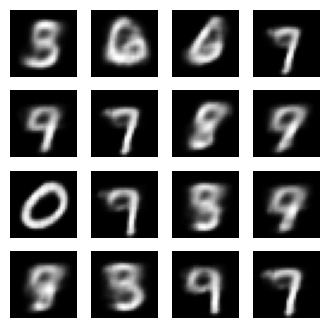

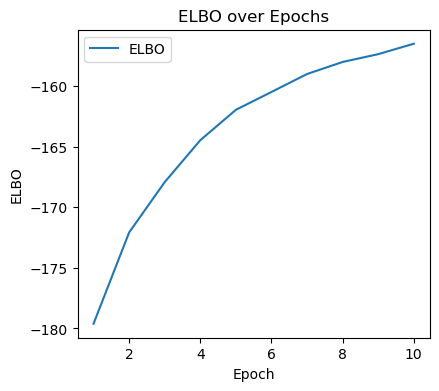

In [21]:
losses = []

generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    
    losses.append(elbo.numpy())
    
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
          .format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)


epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, losses, label='ELBO')
plt.title('ELBO over Epochs')
plt.xlabel('Epoch')
plt.ylabel('ELBO')
plt.legend()

plt.show()

The graph shows the Evidence Lower Bound (ELBO) values over 10 training epochs, with higher values (closer to zero) indicating better model performance. 

From the graph, it appears that the ELBO is improving over time, as the curve slopes upwards as epochs increase. This suggests that the model is learning from the training data and that the difference between the approximate posterior and the true posterior is decreasing, which is the goal when training a variational autoencoder.

### Display an animated GIF of all the saved images

In [22]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


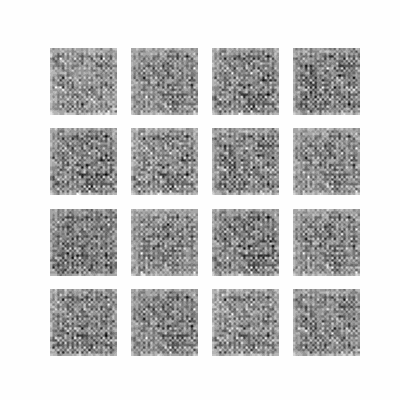

In [23]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### Display a 2D manifold of digits from the latent space

The provided code visualizes a continuous distribution of the different digit classes, transitioning smoothly from one digit class to another within a two-dimensional latent space. It uses TensorFlow Probability to create a latent space characterized by a standard normal distribution.

In [24]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

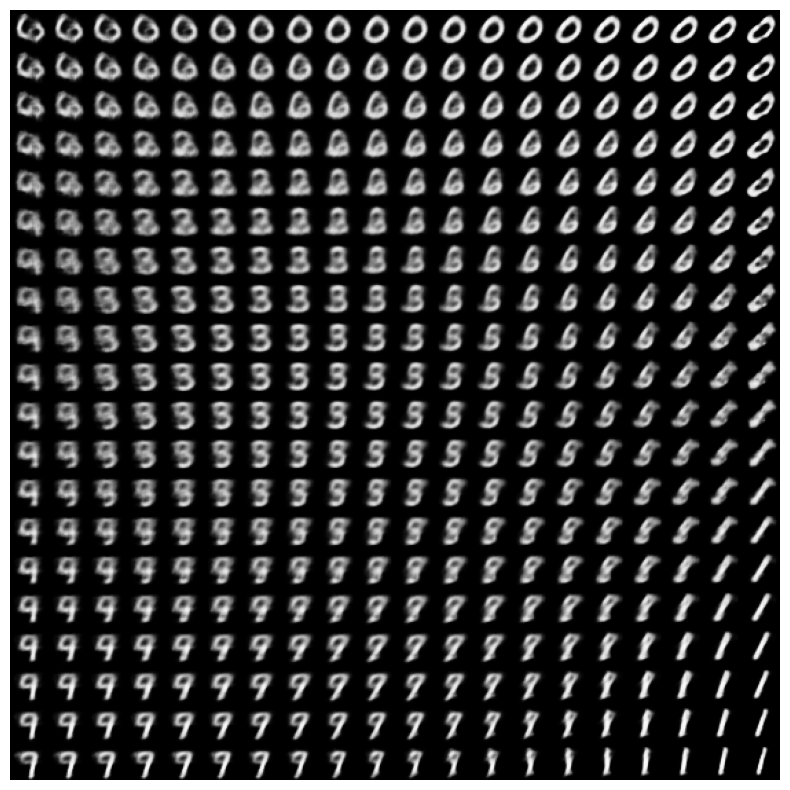

In [25]:
plot_latent_images(model, 20)

# 3. Beta-VAE

The $\beta$-VAE model is a variant of the Variational Autoencoder (VAE) that introduces an adjustable hyperparameter $\beta$ that modifies the impact of the regularization term in the loss function. By increasing $\beta$, one increases the weight of the penalty on the latent space's organization, encouraging the model to learn more disentangled and factorized representations. Disentangled representations are those where single latent units are sensitive to changes in single generative factors, while being relatively invariant to changes in other factors.

While traditional VAE focus on maximizing the likelihood of data by balancing reconstruction quality with latent regularity, $\beta$-VAE modifies this by weighting the KL divergence term with $\beta$. This change allows for control over the trade-off between data reconstruction fidelity and the disentanglement of latent representations. 

Therefore, the objective function from the $\beta$-VAE model results in:

$$
\mathcal{L}(\theta,\phi;\mathbf{x},\mathbf{z},\beta)=\mathbb{E}_{q_\phi(\mathbf{z}|\mathbf{x})}[\log p_\theta(\mathbf{x}|\mathbf{z})]-\beta\left.D_{KL}(q_\phi(\mathbf{z}|\mathbf{x})||p(\mathbf{z})\right)
$$

where $\beta$ acts as the regularization coefficient limiting the capacity of $\mathbf{z}$, exerting implicit pressure for independence on the learned posterior. Adjusting $\beta$ alters the level of learning pressure applied during training, thereby promoting diverse learned representations.

When $\beta$ = 1, the $\beta$-VAE collapses to the standard VAE, where the emphasis is equally balanced between accurate reconstruction and regularization. However, when $\beta>1$ , the $\beta$-VAE puts a stronger emphasis on the regularization term prioritizing learning independent latent factors, potentially at the cost of reconstruction accuracy. In essence, $\beta$-VAE extends the VAE framework to provide a more structured and interpretable latent space, facilitating better generalization and more meaningful representation of data features. 

Paper from Higgins et al., (2017) demonstrates that $\beta$-VAE with appropriately tuned $\beta>1$ qualitatively outperforms standard VAE ($\beta = 1$) in learning disentangled representations, as it can uncover independent factors without supervision.

<br>
<div style="text-align: center;">
<img src="https://github.com/adam-olivares/Probabilistic_Inference_VAE/blob/main/Screenshot%202024-03-04%20at%2019.56.51.png?raw=true" width="450"/>
<div style="margin-top: 10px;">Figure 3: Comparison between VAE and $\beta$-VAE generated images. Only $\beta$-VAE learnt to disentangle attributes like azimuth, emotion and hair style.</div>
<div style="margin-top: 5px; font-size: smaller; color: grey;">Image source: (Higgins et al., 2017)</div>
</div>

# 4. Conclusion

The distinguished ability of Variational Autoencoders to accurately model and approximate the complexities of intractable posterior distributions, coupled with its effective integration with neural networks, has been instrumental in the evolution of probabilistic modeling. In an effort to make this complex method more approachable, we have aimed to clarify its practical use through a detailed tutorial, specifically designed for those with limited statistical knowledge.

Additionally, we have introducted $\beta$-VAE, which is an extension of the classical VAE framework, which is better suited for discovering disentangled latent factors, thus enhancing the interpretability of the latent space. By presenting the $\beta$-VAE, we aim to highlight some of the noteworthy extensions of the classical VAE found in the current literature, sparking curiosity among readers about the potential and capabilities of this method.

# References

* Kingma, D. P., & Welling, M. (2019). An Introduction to Variational Autoencoders. arXiv. https://arxiv.org/abs/1906.02691
* TensorFlow. Variational AutoEncoder. Retrieved from https://www.tensorflow.org/tutorials/generative/cvae
* Weng, L. (2018). A Beginner's Guide to Variational Autoencoders (VAEs). Retrieved from https://lilianweng.github.io/posts/2018-08-12-vae/
* Higgins, I., Matthey, L., Pal, A., Burgess, C., Glorot, X., Botvinick, M., Mohamed, S., & Lerchner, A. (2017). Beta-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework. In International Conference on Learning Representations (ICLR). OpenReview. https://openreview.net/forum?id=Sy2fzU9gl